In [1]:
import tensorflow as tf
import tensorflow.keras as ks
import matplotlib.pyplot as plt
import io
import os
#! pip install tensorflow-datasets
# use built-in dataset in tensorflow
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers
from tensorboard.plugins import projector


Different strategies to convert words into vectors
    1. Bag of Words
    2. TF-IDF
    3. One-Hot Encoding
    4. Word Embeddings:
          4.1 Word2Vec (CBOW, Skip-gram)          
          4.2 GloVe


In [2]:
# creating a layer variable 
embedding_layer  = layers.Embedding(1000, 5)

In [3]:
result = embedding_layer(tf.constant([[1,2,3,6],[1,2,3,6]]))

In [4]:
result.shape

TensorShape([2, 4, 5])

# Load Dataset
The training and test dataset

In [5]:
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k',
                                  split = (tfds.Split.TRAIN, tfds.Split.TEST),
                                   with_info = True, as_supervised = True  )

In [6]:
for obj, label  in train_data.take(1):
    #print(obj)
    print(info.features['text'].ints2str(obj))
    print()
    print('Label: ', label)

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.

Label:  tf.Tensor(0, shape=(), dtype=int64)


In [7]:
# print 10 words
encoder = info.features['text'].encoder
print(encoder.subwords[85:95]) 

['see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ']


# Data Preparation


In [8]:
# for equal Length Input Sequences
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes= ([None],())) 
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes= ([None],())) 

In [9]:
#split into batch and label
train_batch, train_label = next(iter(train_batches))
train_batch, train_label = next(iter(train_batches))

In [10]:
print('Training Sahpe: ',train_batch.numpy().shape)
print('Label Sahpe: ',train_label.numpy().shape)

Training Sahpe:  (10, 655)
Label Sahpe:  (10,)


# Model

Two flavors of Word2Vec models,one where you are given neighboring words called **continuous bag of words (CBOW)**, and the other where  you are given the middle word called **Skip-gram.**

In [14]:
embedding_dim = 32
model =  ks.Sequential()
# continuous bag of words (CBOW)
model.add(layers.Embedding(encoder.vocab_size , embedding_dim)) 
# (Batch, Sequence, Embedding)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))



In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          261920    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 265,089
Trainable params: 265,089
Non-trainable params: 0
_________________________________________________________________


# Compile and Train Model

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])


In [17]:
history = model.fit(train_batches,
                    epochs = 10,
                    validation_data = test_batches,
                    validation_steps = 20)

Epoch 1/10
2500/2500 [==============================] - 27s 11ms/step - loss: 0.4167 - accuracy: 0.7771 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.2370 - accuracy: 0.9004 - val_loss: 0.3085 - val_accuracy: 0.8750
Epoch 3/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1944 - accuracy: 0.9208 - val_loss: 0.4260 - val_accuracy: 0.8400
Epoch 4/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.1663 - accuracy: 0.9337 - val_loss: 0.5019 - val_accuracy: 0.8250
Epoch 5/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1402 - accuracy: 0.9411 - val_loss: 0.5814 - val_accuracy: 0.8550
Epoch 6/10
2500/2500 [==============================] - 19s 7ms/step - loss: 0.1240 - accuracy: 0.9466 - val_loss: 0.4590 - val_accuracy: 0.8750
Epoch 7/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1051 - accuracy: 0.9555 - val_loss: 0.5528

Text(0, 0.5, 'accuracy')

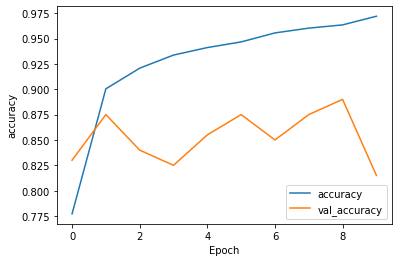

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

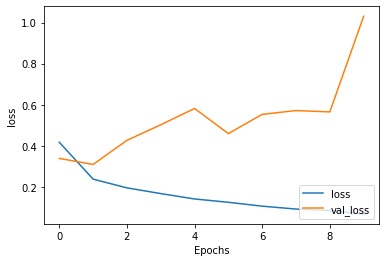

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('loss')

### Visualizing Data using the Embedding Projector in TensorBoard
Using the TensorBoard Embedding Projector, you can graphically represent high dimensional embeddings. This can be helpful in visualizing, examining, and understanding your embedding layers.

In [22]:
# Get the weights of the embedding layer
weights = tf.Variable(model.layers[0].get_weights()[0][1:])

print(weights.shape)

(8184, 32)


In [23]:
log_dir='/logs/imdb-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


In [24]:
log_dir

'/logs/imdb-example/'

In [24]:
# Saving vector data for TensorBoard
out_v = io.open(log_dir + 'vect.tsv','w', encoding = 'utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] #skip 0 it is padding
    out_v.write('\t'.join([str(x) for x in vec]))
    

out_v.close()


In [26]:
# Save Labels separately on a line-by-line manner.
with  io.open(os.path.join(log_dir, 'metadata.tsv'), "w", encoding="utf-8") as f:
    for subwords in encoder.subwords:
        f.write("{}\n".format(subwords))
      # Fill in the rest of the labels with "unknown"
    for unknown in range(1, encoder.vocab_size - len(encoder.subwords)):
        f.write("unknown #{}\n".format(unknown))


In [27]:
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))


'/logs/imdb-example/embedding.ckpt-1'

In [28]:
# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'meta.tsv'
projector.visualize_embeddings(log_dir, config)


Visualize the weights of the embedding layer

In [29]:
%reload_ext tensorboard
%tensorboard --logdir /logs/imdb-example/



Reusing TensorBoard on port 6006 (pid 21044), started 1:51:41 ago. (Use '!kill 21044' to kill it.)